## Plot model performance

Visualize performance on different models on data`2023-12-20` from the wandb API.

In [118]:
import pathlib
import itertools
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import wilcoxon
import seaborn as sns
import wandb

from utils import BodeColorPalette, get_runs_as_list
from src.util.definitions import DATA_ROOT
bode_palette = BodeColorPalette()

In [119]:
# settings
sns.set_theme(context="paper", 
              style="white", 
              font_scale=1, #0.7,
              rc={"savefig.transparent": True, 
                  "axes.grid": False, 
                  "axes.spines.bottom": True,
                  "axes.spines.left": False,
                  "axes.spines.right": False,
                  "axes.spines.top": False,
                  "font.family":'sans-serif',
                  "font.sans-serif":["Helvetica", "Arial"],
                  "xtick.major.pad": 0.0,
                  "xtick.minor.pad": 0.0,
                  "ytick.major.pad": 0.0,
                  "ytick.minor.pad": 0.0,
                  "axes.labelweight": "bold",
                  "axes.labelpad": 2.5,  # standard is 4.0
                  "axes.xmargin": .05,
                 }, 
             )

params = {
    'axes.labelsize': 6,
    'axes.titlesize': 6,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'font.size': 6,
    'svg.fonttype': 'none',  # necessary to have editable text in SVGs
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
}

plt.rcParams.update(params)


# more settings for all plots
errorbar = "se"  # standard error of the mean
errwidth = .9
errcolor = "black"
capsize = .1  # size of the end of the errorbar
linewidth = 1.  # width of the outline of barplot

palette = [
    bode_palette.blues[0], 
    bode_palette.oranges[0],
    bode_palette.blues[2],
    bode_palette.oranges[2],
    bode_palette.blues[3],
    bode_palette.oranges[3]
]


### Get data from wandb API

In [120]:
summary_list, config_list, tag_list, name_list  = get_runs_as_list(filters={"$or":
                                                             [{"jobType": "training"},
                                                              {"jobType": "hparam_best"}
                                                             ]})
df_all = pd.json_normalize(config_list).merge(pd.json_normalize(summary_list), left_index=True, right_index=True)
df_all["tags"] = tag_list
df_all["run_id"] = name_list
df_all["run_group"] = [s.rsplit("_", maxsplit=1)[0] for s in name_list]
df_all["Model+Features"] = df_all["name"] + "/" + df_all["decoder.global_features"].str.join("+").str.replace("None", "CGR")
df_all["fold"] = df_all["run_id"].str[-1].astype(int)

In [121]:
df_all["experiment_id"]

0       JG1525
1       JG1525
2       JG1525
3       JG1525
4       JG1525
         ...  
4094       NaN
4095       NaN
4096       NaN
4097       NaN
4098       NaN
Name: experiment_id, Length: 4099, dtype: object

In [123]:
# filter for relevant data (JG1309 onwards for 2023-12-20 models)
df_all = df_all.loc[df_all["experiment_id"].apply(lambda x: int(x.strip("JG")) > 1308 if isinstance(x, str) else False)]

In [124]:
# check available experiments by split
for tag, row in df_all.groupby("tags")[["experiment_id"]].agg(set).iterrows():
    print(tag, "-->", row["experiment_id"])

('0D', 'production') --> {'JG1349'}
('0D_0.625',) --> {'JG1347', 'JG1345', 'JG1348', 'JG1344', 'JG1346'}
('0D_1.25',) --> {'JG1341', 'JG1340', 'JG1339', 'JG1342', 'JG1343'}
('0D_10',) --> {'JG1325', 'JG1324', 'JG1328', 'JG1326', 'JG1327'}
('0D_2.5',) --> {'JG1335', 'JG1336', 'JG1334', 'JG1338', 'JG1337'}
('0D_20',) --> {'JG1321', 'JG1320', 'JG1319', 'JG1323', 'JG1322'}
('0D_40',) --> {'JG1314', 'JG1316', 'JG1317', 'JG1315', 'JG1318'}
('0D_5',) --> {'JG1329', 'JG1330', 'JG1332', 'JG1331', 'JG1333'}
('0D_80',) --> {'JG1482', 'JG1481', 'JG1312', 'JG1310', 'JG1309', 'JG1311', 'JG1483', 'JG1313', 'JG1480'}
('1D',) --> {'JG1486', 'JG1491', 'JG1484', 'JG1492', 'JG1490', 'JG1489', 'JG1485', 'JG1487', 'JG1488'}
('1D_10',) --> {'JG1367', 'JG1366', 'JG1365', 'JG1368', 'JG1369'}
('1D_2.5',) --> {'JG1378', 'JG1376', 'JG1379', 'JG1375', 'JG1377'}
('1D_20',) --> {'JG1360', 'JG1361', 'JG1363', 'JG1364', 'JG1362'}
('1D_40',) --> {'JG1357', 'JG1358', 'JG1355', 'JG1356', 'JG1359'}
('1D_5',) --> {'JG1374'

In [125]:
# set dir where we will save plots
analysis_dir = pathlib.Path("results")
# set date (of the dataset) for saving
datadate = "2023-12-20"

In [126]:
split_stats = pd.read_csv(DATA_ROOT / "splits" / f"split_statistics_{datadate}.csv")

def get_chance_ap(split_name, fold=None, set_type="test"):
    df = pd.read_csv(DATA_ROOT / "splits" / f"split_statistics_{datadate}.csv")
    if fold is not None:
        return df.loc[(df["split_name"] == split_name ) & (df["fold"] == fold), f"Chance level average precision macro on {set_type} set"].item()
    else:
        return df.loc[(df["split_name"] == split_name ), f"Chance level average precision macro on {set_type} set"].mean()
    
def get_sample_count(split_name, fold=None):
    df = pd.read_csv(DATA_ROOT / "splits" / f"split_statistics_{datadate}.csv")
    if fold is not None:
        return int(df.loc[(df["split_name"] == split_name) & (df["fold"] == fold), "Train samples"].item().split()[0])
    else:
        return int(df.loc[df["split_name"] == split_name, "Train samples"].str.split(expand=True)[0].astype("int").mean())    
    
        
def get_buildingblock_count(split_name, fold=None, bb_types=["initiators", "monomers", "terminators"]):
    df = pd.read_csv(DATA_ROOT / "splits" / f"split_statistics_{datadate}.csv")
    for s in bb_types:
        if s not in ["initiators", "monomers", "terminators"]:  # catch incorrect options for bulding blocks
            raise ValueError("This building block type does not exist")
    columns = [f"Train {s}" for s in bb_types]
    if fold is not None:
        return df.loc[(df["split_name"] == split_name) & (df["fold"] == fold), columns].mean(axis=None)
    else:
        return df.loc[df["split_name"] == split_name, columns].mean(axis=None)
    

## 0D split

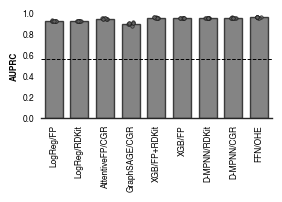

In [38]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "0D_80"
# choose the colorscheme
fill_color = '0.4'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
# choose the data to plot
experiment_ids = [
    "JG1480",  # LogReg/FP
    "JG1483",  # LogReg/RDKit
    "JG1481",  # AttentiveFP/CGR
    "JG1482",  # GraphSAGE/CGR
    "JG1311",  # XGB/FP+RDKit
    "JG1310",  # XGB/FP
    "JG1313",  # DMPNN/CGR+RDKit
    "JG1312",  # DMPNN/CGR
    "JG1309",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(get_chance_ap(tag, set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/0D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()

fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_barplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_barplot.png", dpi=300)

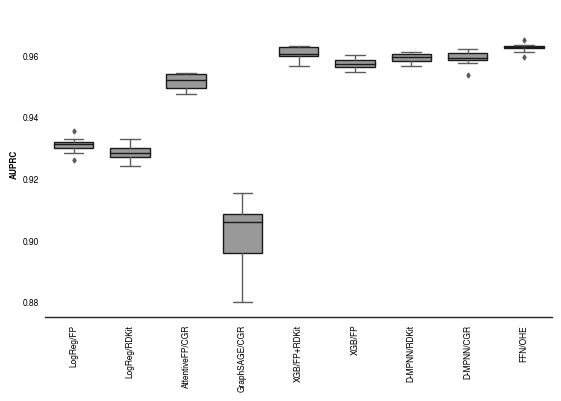

In [15]:
# try the same with a boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "0D_80"
# choose the colorscheme
fill_color = '0.6'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
experiment_ids = [
    "JG1480",  # LogReg/FP
    "JG1483",  # LogReg/RDKit
    "JG1481",  # AttentiveFP/CGR
    "JG1482",  # GraphSAGE/CGR
    "JG1311",  # XGB/FP+RDKit
    "JG1310",  # XGB/FP
    "JG1313",  # DMPNN/CGR+RDKit
    "JG1312",  # DMPNN/CGR
    "JG1309",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6,4))
sns.boxplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    boxprops={"edgecolor": stroke_color},
    medianprops={"color": stroke_color},
    color=fill_color,
    linewidth=linewidth,
    fliersize=2.5,
    saturation=.8,
    width=.7,
)

ax.set_ylabel("AUPRC")
ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.875, 0.975))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()

fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_boxplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_boxplot.png", dpi=300)

/tmp/ipykernel_6005/413294356.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


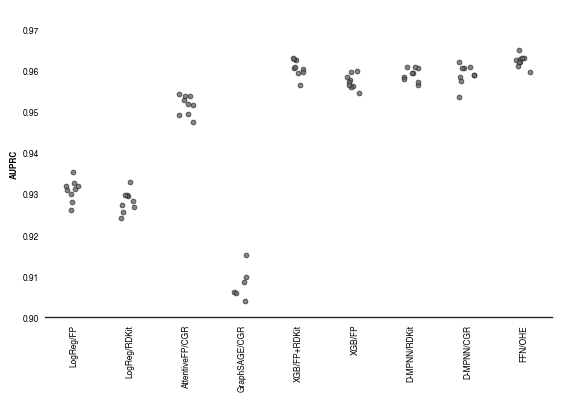

In [11]:
# try the same with a data points only
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "0D_80"
# choose the colorscheme
fill_color = '0.4'  # grey
stroke_color = '0.1'  # almost black

# choose the data to plot
experiment_ids = [
    "JG1480",  # LogReg/FP
    "JG1483",  # LogReg/RDKit
    "JG1481",  # AttentiveFP/CGR
    "JG1482",  # GraphSAGE/CGR
    "JG1311",  # XGB/FP+RDKit
    "JG1310",  # XGB/FP
    "JG1313",  # DMPNN/CGR+RDKit
    "JG1312",  # DMPNN/CGR
    "JG1309",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6,4))

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              jitter=.15,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=3.5,
              alpha=.8
             )

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.9, 0.975))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()

fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_scatter.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_scatter.png", dpi=300)

In [16]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
FFN/OHE,0.962412,0.001507
XGB/FP+RDKit,0.960639,0.002066
D-MPNN/CGR,0.959092,0.002506
D-MPNN/RDKit,0.959078,0.001592
XGB/FP,0.957347,0.001722
AttentiveFP/CGR,0.951590,0.002411
LogisticRegression/FP,0.930891,0.002655
LogisticRegression/RDKit,0.928263,0.002602
GraphSAGE/CGR,0.902271,0.010478


In [17]:
# is the best model significantly better than the rest?
best = "FFN/OHE"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

LogisticRegression/FP :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
LogisticRegression/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
AttentiveFP/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
GraphSAGE/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/FP+RDKit :	 WilcoxonResult(statistic=2.0, pvalue=0.01171875)
XGB/FP :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
D-MPNN/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
D-MPNN/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)


## 1D split

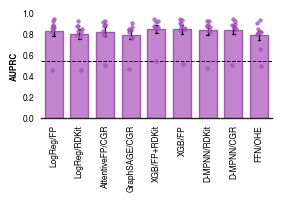

In [29]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
experiment_ids = [
    "JG1484",  # LogReg/FP
    "JG1485",  # LogReg/RDKit
    "JG1491",  # AttentiveFP/CGR
    "JG1492",  # GraphSAGE/CGR
    "JG1487",  # XGB/FP+RDKit
    "JG1486",  # XGB/FP
    "JG1490",  # DMPNN/CGR+RDKit
    "JG1489",  # DMPNN/CGR
    "JG1488",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(get_chance_ap("1D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/1D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_barplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_barplot.png", dpi=300)

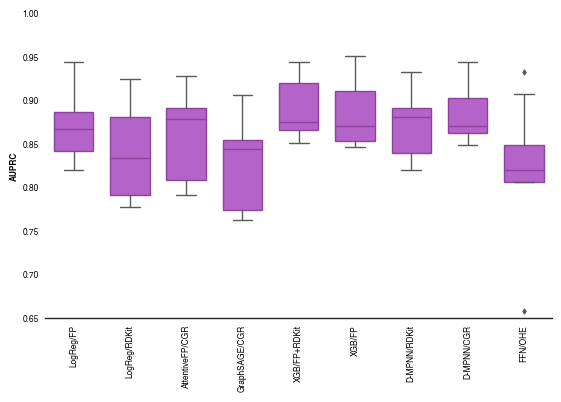

In [31]:
# make a boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
experiment_ids = [
    "JG1484",  # LogReg/FP
    "JG1485",  # LogReg/RDKit
    "JG1491",  # AttentiveFP/CGR
    "JG1492",  # GraphSAGE/CGR
    "JG1487",  # XGB/FP+RDKit
    "JG1486",  # XGB/FP
    "JG1490",  # DMPNN/CGR+RDKit
    "JG1489",  # DMPNN/CGR
    "JG1488",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.boxplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    color=fill_color,
    boxprops={"edgecolor": stroke_color},
    medianprops={"color": stroke_color},
    linewidth=linewidth,
    fliersize=2.5,
    saturation=.8,
    width=.7,
)

ax.axhline(get_chance_ap("1D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/1D
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.65, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_boxplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_boxplot.png", dpi=300)

/tmp/ipykernel_6005/1029465592.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


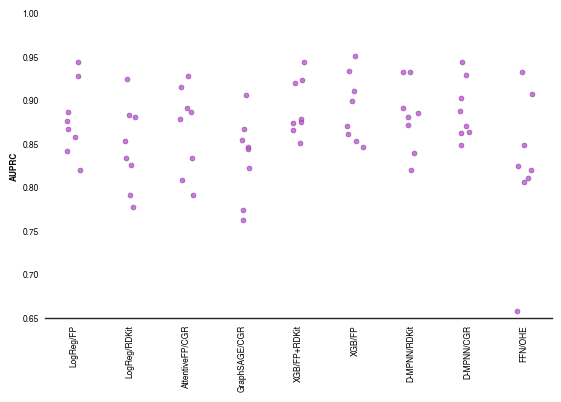

In [33]:
# make a boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "1D"
# choose the colorscheme
fill_color = (189/256, 87/256, 213/256)
stroke_color = (140/256, 67/256, 158/256)

# choose the data to plot
experiment_ids = [
    "JG1484",  # LogReg/FP
    "JG1485",  # LogReg/RDKit
    "JG1491",  # AttentiveFP/CGR
    "JG1492",  # GraphSAGE/CGR
    "JG1487",  # XGB/FP+RDKit
    "JG1486",  # XGB/FP
    "JG1490",  # DMPNN/CGR+RDKit
    "JG1489",  # DMPNN/CGR
    "JG1488",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              jitter=.15,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=3.5,
              alpha=.8
             )

ax.axhline(get_chance_ap("1D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/1D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.65, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_scatter.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_scatter.png", dpi=300)

In [34]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
XGB/FP+RDKit,0.853191,0.119951
XGB/FP,0.849784,0.129303
D-MPNN/CGR,0.846761,0.130999
D-MPNN/RDKit,0.837745,0.137907
LogisticRegression/FP,0.831762,0.144048
AttentiveFP/CGR,0.826943,0.128448
LogisticRegression/RDKit,0.803616,0.136932
GraphSAGE/CGR,0.794832,0.128017
FFN/OHE,0.790156,0.133217


In [37]:
# is the best model significantly better than the rest?
best = "XGB/FP+RDKit"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

LogisticRegression/FP :	 WilcoxonResult(statistic=6.0, pvalue=0.0546875)
LogisticRegression/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
AttentiveFP/CGR :	 WilcoxonResult(statistic=3.0, pvalue=0.01953125)
GraphSAGE/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/FP :	 WilcoxonResult(statistic=19.0, pvalue=0.734375)
D-MPNN/RDKit :	 WilcoxonResult(statistic=10.0, pvalue=0.1640625)
D-MPNN/CGR :	 WilcoxonResult(statistic=17.0, pvalue=0.5703125)
FFN/OHE :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)


## 2D split

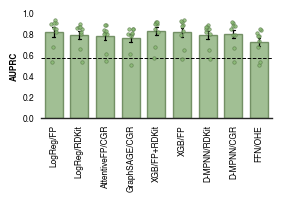

In [47]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
experiment_ids = [
    "JG1493",  # LogReg/FP
    "JG1494",  # LogReg/RDKit
    "JG1500",  # AttentiveFP/CGR
    "JG1501",  # GraphSAGE/CGR
    "JG1496",  # XGB/FP+RDKit
    "JG1495",  # XGB/FP
    "JG1499",  # DMPNN/CGR+RDKit
    "JG1498",  # DMPNN/CGR
    "JG1497",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()

# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(get_chance_ap("2D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/2D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_barplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_barplot.png", dpi=300)

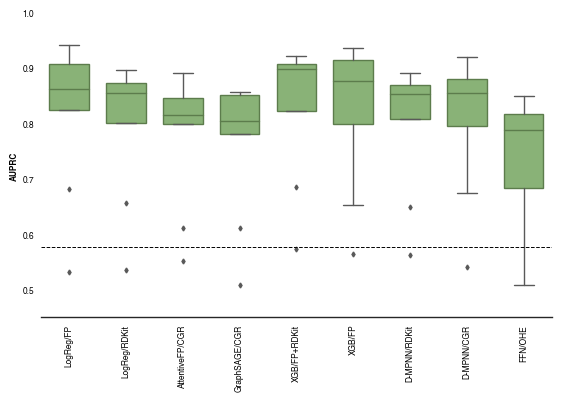

In [50]:
# make boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
experiment_ids = [
    "JG1493",  # LogReg/FP
    "JG1494",  # LogReg/RDKit
    "JG1500",  # AttentiveFP/CGR
    "JG1501",  # GraphSAGE/CGR
    "JG1496",  # XGB/FP+RDKit
    "JG1495",  # XGB/FP
    "JG1499",  # DMPNN/CGR+RDKit
    "JG1498",  # DMPNN/CGR
    "JG1497",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()

# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.boxplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    color=fill_color,
    boxprops={"edgecolor": stroke_color},
    medianprops={"color": stroke_color},
    linewidth=linewidth,
    fliersize=2.5,
    saturation=.8,
    width=.7,
)

ax.axhline(get_chance_ap("2D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/2D
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.45, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_boxplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_boxplot.png", dpi=300)

/tmp/ipykernel_6005/1159009866.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


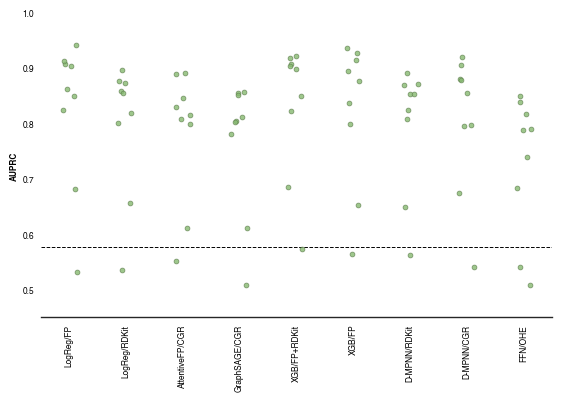

In [73]:
# make boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "2D"
# choose the colorscheme
fill_color = (
    135/256,
    186/256,
    112/256,
)

stroke_color = (92/256, 124/256, 76/256)

# choose the data to plot
experiment_ids = [
    "JG1493",  # LogReg/FP
    "JG1494",  # LogReg/RDKit
    "JG1500",  # AttentiveFP/CGR
    "JG1501",  # GraphSAGE/CGR
    "JG1496",  # XGB/FP+RDKit
    "JG1495",  # XGB/FP
    "JG1499",  # DMPNN/CGR+RDKit
    "JG1498",  # DMPNN/CGR
    "JG1497",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()

# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              jitter=.15,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=3.5,
              alpha=.8
             )

ax.axhline(get_chance_ap("2D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/2D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.45, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_scatter.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_scatter.png", dpi=300)

In [74]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
XGB/FP+RDKit,0.830812,0.122467
LogisticRegression/FP,0.823711,0.133272
XGB/FP,0.822209,0.130610
D-MPNN/CGR,0.805058,0.124720
D-MPNN/RDKit,0.797655,0.113956
LogisticRegression/RDKit,0.796684,0.121317
AttentiveFP/CGR,0.782180,0.119720
GraphSAGE/CGR,0.764374,0.121712
FFN/OHE,0.728263,0.126478


In [75]:
# is the best model significantly better than the rest?
best = "XGB/FP+RDKit"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

LogisticRegression/FP :	 WilcoxonResult(statistic=15.0, pvalue=0.42578125)
LogisticRegression/RDKit :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
AttentiveFP/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
GraphSAGE/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
XGB/FP :	 WilcoxonResult(statistic=12.0, pvalue=0.25)
D-MPNN/RDKit :	 WilcoxonResult(statistic=1.0, pvalue=0.0078125)
D-MPNN/CGR :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)
FFN/OHE :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)


## 3D split

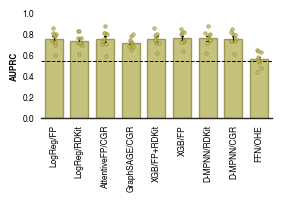

In [76]:
# barplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1502",  # LogReg/FP
    "JG1503",  # LogReg/RDKit
    "JG1509",  # AttentiveFP/CGR
    "JG1510",  # GraphSAGE/CGR
    "JG1505",  # XGB/FP+RDKit
    "JG1504",  # XGB/FP
    "JG1508",  # DMPNN/CGR+RDKit
    "JG1507",  # DMPNN/CGR
    "JG1506",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(2.8,2))
sns.barplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    errorbar=errorbar,
    errwidth=errwidth,
    errcolor=errcolor,
    capsize=capsize,
    color=fill_color,
    edgecolor=stroke_color,
    linewidth=linewidth,
    alpha=.8,
    width=.7,
)

sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=2.5,
              alpha=.8
             )

ax.axhline(get_chance_ap("3D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/3D
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0, 1))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_barplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_barplot.png", dpi=300)

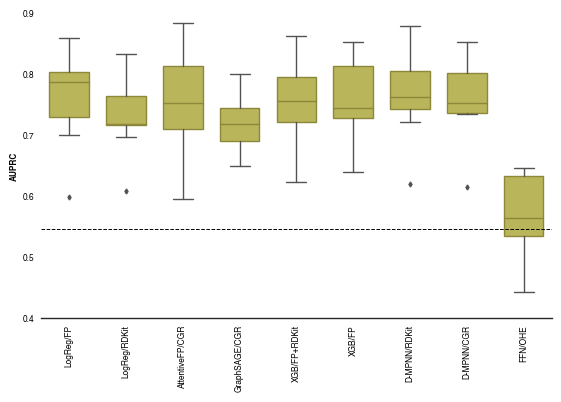

In [58]:
# boxplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1502",  # LogReg/FP
    "JG1503",  # LogReg/RDKit
    "JG1509",  # AttentiveFP/CGR
    "JG1510",  # GraphSAGE/CGR
    "JG1505",  # XGB/FP+RDKit
    "JG1504",  # XGB/FP
    "JG1508",  # DMPNN/CGR+RDKit
    "JG1507",  # DMPNN/CGR
    "JG1506",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.boxplot(
    ax=ax,
    data=df_plot, 
    x="Model+Features",
    y=metric,
    color=fill_color,
    boxprops={"edgecolor": stroke_color},
    medianprops={"color": stroke_color},
    linewidth=linewidth,
    fliersize=2.5,
    saturation=.8,
    width=.7,
)

ax.axhline(get_chance_ap("3D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/3D

ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.4, 0.9))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_boxplot.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_boxplot.png", dpi=300)

/tmp/ipykernel_6005/405242194.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


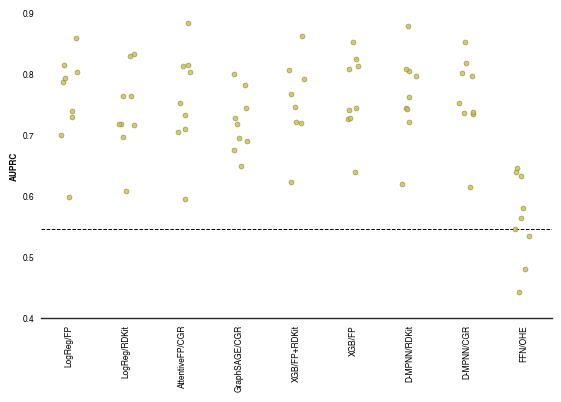

In [69]:
# scatter
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1502",  # LogReg/FP
    "JG1503",  # LogReg/RDKit
    "JG1509",  # AttentiveFP/CGR
    "JG1510",  # GraphSAGE/CGR
    "JG1505",  # XGB/FP+RDKit
    "JG1504",  # XGB/FP
    "JG1508",  # DMPNN/CGR+RDKit
    "JG1507",  # DMPNN/CGR
    "JG1506",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.stripplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              dodge=True,
              jitter=.15,
              edgecolor=stroke_color,
              color=fill_color,
              linewidth=.5,
              legend=False,
              marker="o",
              size=3.5,
              alpha=.8
)

ax.axhline(get_chance_ap("3D", set_type="val"), ls="--", color="black", linewidth=.7)  # chance level for val/3D
ax.set_xlabel(None)
ax.set_ylabel("AUPRC")
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.4, 0.9))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_scatter.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_scatter.png", dpi=300)

/tmp/ipykernel_6005/3968006909.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


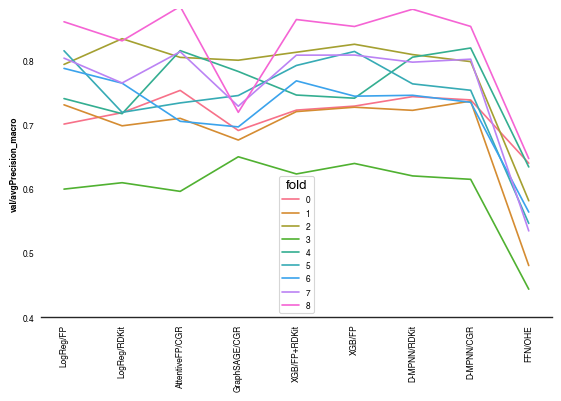

In [65]:
# try a lineplot
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1502",  # LogReg/FP
    "JG1503",  # LogReg/RDKit
    "JG1509",  # AttentiveFP/CGR
    "JG1510",  # GraphSAGE/CGR
    "JG1505",  # XGB/FP+RDKit
    "JG1504",  # XGB/FP
    "JG1508",  # DMPNN/CGR+RDKit
    "JG1507",  # DMPNN/CGR
    "JG1506",  # FFN/OHE
]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.lineplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              hue="fold", 
              palette=sns.color_palette("husl", 9),
              #edgecolor=stroke_color,
              #color=fill_color,
              #linewidth=.5,
              #legend=False,
              #marker="o",
              #size=3.5,
              #alpha=.8
)

ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.4, 0.88))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_line.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_line.png", dpi=300)

/tmp/ipykernel_6005/3247609882.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))


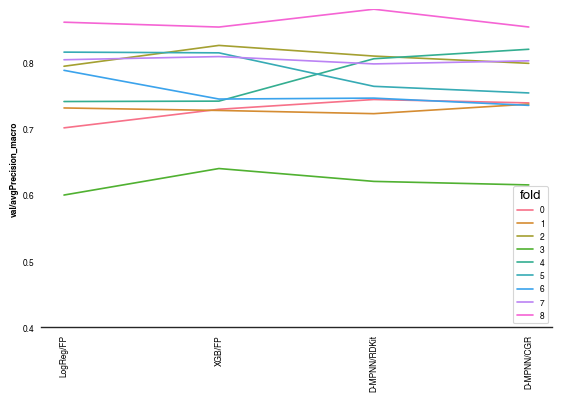

In [63]:
# same, but only best models
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"
# choose the task (0D, 1D, or 2D)
tag = "3D"
# choose the colorscheme
fill_color = (198/256, 193/256, 80/256)

stroke_color = (142/256, 136/256, 58/256)

# choose the data to plot
experiment_ids = [
    "JG1502",  # LogReg/FP
    "JG1504",  # XGB/FP
    "JG1508",  # DMPNN/CGR+RDKit
    "JG1507",  # DMPNN/CGR

]

# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(experiment_ids) & df_all['tags'].apply(lambda x: tag in x)]

# sort the values
sort_dict = dict(zip(experiment_ids, itertools.count()))
df_plot = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict))
ticklabels = df_plot["Model+Features"].unique().tolist()
# set plot
fig, ax = plt.subplots(figsize=(5.6, 4))
sns.lineplot(
    ax=ax,
    data=df_plot, 
              x="Model+Features",
              y=metric,
              hue="fold", 
              palette=sns.color_palette("husl", 9),
              #edgecolor=stroke_color,
              #color=fill_color,
              #linewidth=.5,
              #legend=False,
              #marker="o",
              #size=3.5,
              #alpha=.8
)

ax.set_xlabel(None)
ax.xaxis.set_tick_params(labelrotation=90)
ax.set_ylim((0.4, 0.88))
ax.xaxis.set_ticklabels(df_plot["Model+Features"].drop_duplicates().str.replace("LogisticRegression", "LogReg"))

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_line.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_{tag}_models_{metric.replace('/', '_')}_line.png", dpi=300)

In [77]:
df_plot.groupby("Model+Features")["val/avgPrecision_macro"].agg([np.mean, np.std]).sort_values(by="mean", ascending=False)

,mean,std
Model+Features,,
D-MPNN/RDKit,0.765076,0.071943
XGB/FP,0.764512,0.066235
D-MPNN/CGR,0.761099,0.069033
LogisticRegression/FP,0.759030,0.076911
AttentiveFP/CGR,0.757234,0.083957
XGB/FP+RDKit,0.755470,0.071611
LogisticRegression/RDKit,0.739495,0.069281
GraphSAGE/CGR,0.720977,0.049171
FFN/OHE,0.563410,0.071168


In [79]:
# is the best model significantly better than the rest?
best = "D-MPNN/RDKit"
x = df_plot.loc[df_plot["Model+Features"] == best].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
for i in df_plot["Model+Features"].drop_duplicates():
    if i != best:
        y = df_plot.loc[df_plot["Model+Features"] == i].sort_values(by="run_id")["val/avgPrecision_macro"].to_numpy()
        print(i, ":\t", wilcoxon(x, y, alternative="two-sided"))

LogisticRegression/FP :	 WilcoxonResult(statistic=17.0, pvalue=0.5703125)
LogisticRegression/RDKit :	 WilcoxonResult(statistic=6.0, pvalue=0.0546875)
AttentiveFP/CGR :	 WilcoxonResult(statistic=14.0, pvalue=0.359375)
GraphSAGE/CGR :	 WilcoxonResult(statistic=4.0, pvalue=0.02734375)
XGB/FP+RDKit :	 WilcoxonResult(statistic=nan, pvalue=nan)
XGB/FP :	 WilcoxonResult(statistic=21.0, pvalue=0.91015625)
D-MPNN/CGR :	 WilcoxonResult(statistic=16.0, pvalue=0.49609375)
FFN/OHE :	 WilcoxonResult(statistic=0.0, pvalue=0.00390625)


## 0D restricted data splits

In [127]:
palette = sns.color_palette(["#5790fc", "#f89c20", "#964a8b", "#e42536"])  # works for colorblind
palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.5882352941176471, 0.2901960784313726, 0.5450980392156862),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294)]

In [128]:
# some settings for all following plots

# order used for hue/style
order = ['FFN/OHE', 'XGB/FP', 'XGB/FP+RDKit', 'D-MPNN/CGR', 'D-MPNN/RDKit']

# linestyle
dashes=[(3, 3), (3, 3), (1, 1), (3, 3), (1, 1)]

# alternative palette where two colors are reused with less saturation to show derivative categories
palette = sns.color_palette(["#5790fc", "#f89c20", "#a66611", "#a0228d", "#783b6e"])  # works for colorblind
palette = sns.color_palette(["#5790fc", "#f89c20", "#a66611", "#e42536", "#a1212c"])  # works for colorblind
palette

[(0.3411764705882353, 0.5647058823529412, 0.9882352941176471),
 (0.9725490196078431, 0.611764705882353, 0.12549019607843137),
 (0.6509803921568628, 0.4, 0.06666666666666667),
 (0.8941176470588236, 0.1450980392156863, 0.21176470588235294),
 (0.6313725490196078, 0.12941176470588237, 0.17254901960784313)]

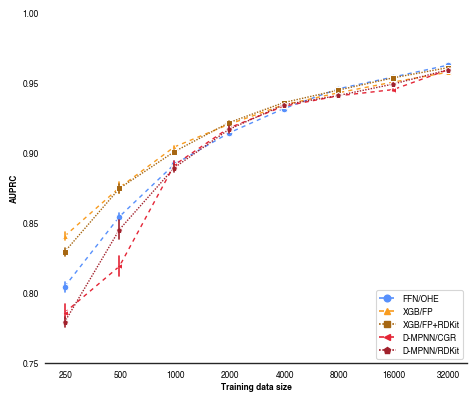

In [73]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _0.625
            "JG1344",  # FFN/OHE
            "JG1345",  # XGB/FP
            "JG1346",  # XGB/FP+RDKit
            "JG1347",  # D-MPNN/CGR
            "JG1348",  # D-MPNN/CGR+RDKit 
    ],
        [  # _1.25
            "JG1339",  # FFN/OHE
            "JG1340",  # XGB/FP
            "JG1341",  # XGB/FP+RDKit
            "JG1342",  # D-MPNN/CGR
            "JG1343",  # D-MPNN/CGR+RDKit 
    ],
        [  # _2.5
            "JG1334",  # FFN/OHE
            "JG1335",  # XGB/FP
            "JG1336",  # XGB/FP+RDKit
            "JG1337",  # D-MPNN/CGR
            "JG1338",  # D-MPNN/CGR+RDKit 
    ],
        [  # _5
            "JG1329",  # FFN/OHE
            "JG1330",  # XGB/FP
            "JG1331",  # XGB/FP+RDKit
            "JG1332",  # D-MPNN/CGR
            "JG1333",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1324",  # FFN/OHE
            "JG1325",  # XGB/FP
            "JG1326",  # XGB/FP+RDKit
            "JG1327",  # D-MPNN/CGR
            "JG1328",  # D-MPNN/CGR+RDKit 
    ],
        [  # _20
            "JG1319",  # FFN/OHE
            "JG1320",  # XGB/FP
            "JG1321",  # XGB/FP+RDKit
            "JG1322",  # D-MPNN/CGR
            "JG1323",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1314",  # FFN/OHE
            "JG1315",  # XGB/FP
            "JG1316",  # XGB/FP+RDKit
            "JG1317",  # D-MPNN/CGR
            "JG1318",  # D-MPNN/CGR+RDKit 
    ],
        [  # _80 (= full)
            "JG1309",  # FFN/OHE
            "JG1310",  # XGB/FP
            "JG1311",  # XGB/FP+RDKit
            "JG1312",  # D-MPNN/CGR
            "JG1313",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["0D_0.625", "0D_1.25", "0D_2.5", "0D_5", "0D_10","0D_20", "0D_40", "0D_80"]
}

chance_level = [get_chance_ap(k, set_type="val") for k in sample_counts.keys()]  # same order as sample_counts

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)
# don't plot chance level b/c it is much lower
#sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set_ylim((0.75, 1))
ax.set_xticks(
    [250, 500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['250', '500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(title=None, loc="lower right")

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_0D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_0D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

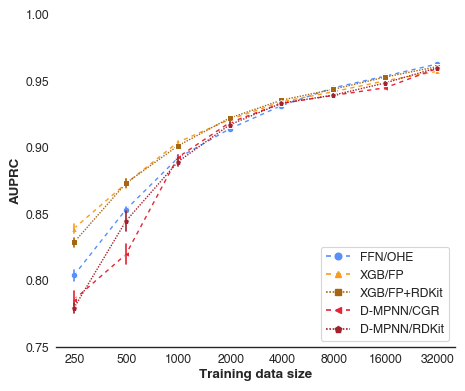

In [63]:
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _0.625
            "JG1344",  # FFN/OHE
            "JG1345",  # XGB/FP
            "JG1346",  # XGB/FP+RDKit
            "JG1347",  # D-MPNN/CGR
            "JG1348",  # D-MPNN/CGR+RDKit 
    ],
        [  # _1.25
            "JG1339",  # FFN/OHE
            "JG1340",  # XGB/FP
            "JG1341",  # XGB/FP+RDKit
            "JG1342",  # D-MPNN/CGR
            "JG1343",  # D-MPNN/CGR+RDKit 
    ],
        [  # _2.5
            "JG1334",  # FFN/OHE
            "JG1335",  # XGB/FP
            "JG1336",  # XGB/FP+RDKit
            "JG1337",  # D-MPNN/CGR
            "JG1338",  # D-MPNN/CGR+RDKit 
    ],
        [  # _5
            "JG1329",  # FFN/OHE
            "JG1330",  # XGB/FP
            "JG1331",  # XGB/FP+RDKit
            "JG1332",  # D-MPNN/CGR
            "JG1333",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1324",  # FFN/OHE
            "JG1325",  # XGB/FP
            "JG1326",  # XGB/FP+RDKit
            "JG1327",  # D-MPNN/CGR
            "JG1328",  # D-MPNN/CGR+RDKit 
    ],
        [  # _20
            "JG1319",  # FFN/OHE
            "JG1320",  # XGB/FP
            "JG1321",  # XGB/FP+RDKit
            "JG1322",  # D-MPNN/CGR
            "JG1323",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1314",  # FFN/OHE
            "JG1315",  # XGB/FP
            "JG1316",  # XGB/FP+RDKit
            "JG1317",  # D-MPNN/CGR
            "JG1318",  # D-MPNN/CGR+RDKit 
    ],
        [  # _80 (= full)
            "JG1309",  # FFN/OHE
            "JG1310",  # XGB/FP
            "JG1311",  # XGB/FP+RDKit
            "JG1312",  # D-MPNN/CGR
            "JG1313",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["0D_0.625", "0D_1.25", "0D_2.5", "0D_5", "0D_10","0D_20", "0D_40", "0D_80"]
}

chance_level = [get_chance_ap(k, set_type="test") for k in sample_counts.keys()]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

# don't plot chance level b/c it is much lower
#sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.set_ylim((0.75, 1))
ax.set_xticks(
    [250, 500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['250', '500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(loc="lower right", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_0D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_0D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

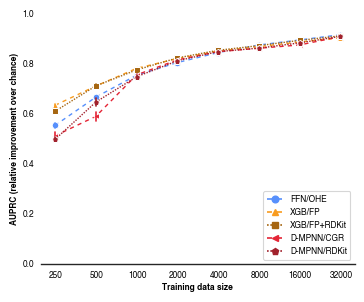

In [74]:
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"


# choose the data to plot
experiment_ids = [
        [  # _0.625
            "JG1344",  # FFN/OHE
            "JG1345",  # XGB/FP
            "JG1346",  # XGB/FP+RDKit
            "JG1347",  # D-MPNN/CGR
            "JG1348",  # D-MPNN/CGR+RDKit 
    ],
        [  # _1.25
            "JG1339",  # FFN/OHE
            "JG1340",  # XGB/FP
            "JG1341",  # XGB/FP+RDKit
            "JG1342",  # D-MPNN/CGR
            "JG1343",  # D-MPNN/CGR+RDKit 
    ],
        [  # _2.5
            "JG1334",  # FFN/OHE
            "JG1335",  # XGB/FP
            "JG1336",  # XGB/FP+RDKit
            "JG1337",  # D-MPNN/CGR
            "JG1338",  # D-MPNN/CGR+RDKit 
    ],
        [  # _5
            "JG1329",  # FFN/OHE
            "JG1330",  # XGB/FP
            "JG1331",  # XGB/FP+RDKit
            "JG1332",  # D-MPNN/CGR
            "JG1333",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1324",  # FFN/OHE
            "JG1325",  # XGB/FP
            "JG1326",  # XGB/FP+RDKit
            "JG1327",  # D-MPNN/CGR
            "JG1328",  # D-MPNN/CGR+RDKit 
    ],
        [  # _20
            "JG1319",  # FFN/OHE
            "JG1320",  # XGB/FP
            "JG1321",  # XGB/FP+RDKit
            "JG1322",  # D-MPNN/CGR
            "JG1323",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1314",  # FFN/OHE
            "JG1315",  # XGB/FP
            "JG1316",  # XGB/FP+RDKit
            "JG1317",  # D-MPNN/CGR
            "JG1318",  # D-MPNN/CGR+RDKit 
    ],
        [  # _80 (= full)
            "JG1309",  # FFN/OHE
            "JG1310",  # XGB/FP
            "JG1311",  # XGB/FP+RDKit
            "JG1312",  # D-MPNN/CGR
            "JG1313",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["0D_0.625", "0D_1.25", "0D_2.5", "0D_5", "0D_10","0D_20", "0D_40", "0D_80"]
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(3.625, 3))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0, 1))
ax.set_xticks(
    [250, 500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['250', '500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(loc="lower right", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_0D_restricted-data_models_{metric.replace('/', '_')}_relative.svg", format="svg", transparent=True)
fig.savefig(analysis_dir / f"metrics_{datadate}_0D_restricted-data_models_{metric.replace('/', '_')}_relative.png", dpi=300)

## 1D restricted data splits

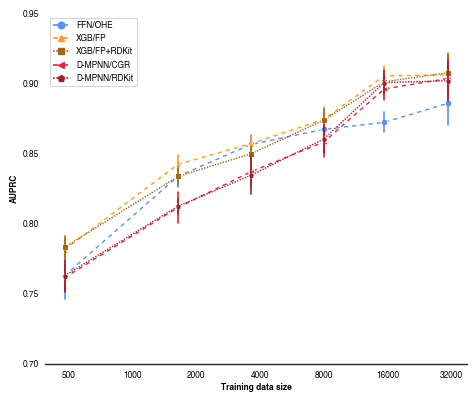

In [138]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _2.5
            "JG1375",  # FFN/OHE
            "JG1376",  # XGB/FP
            "JG1377",  # XGB/FP+RDKit
            "JG1378",  # D-MPNN/CGR
            "JG1379",  # D-MPNN/CGR+RDKit
    ],
        [  # _5
            "JG1370",  # FFN/OHE
            "JG1371",  # XGB/FP
            "JG1372",  # XGB/FP+RDKit
            "JG1373",  # D-MPNN/CGR
            "JG1374",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1365",  # FFN/OHE
            "JG1366",  # XGB/FP
            "JG1367",  # XGB/FP+RDKit
            "JG1368",  # D-MPNN/CGR
            "JG1369",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1360",  # FFN/OHE
            "JG1361",  # XGB/FP
            "JG1362",  # XGB/FP+RDKit
            "JG1363",  # D-MPNN/CGR
            "JG1364",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1355",  # FFN/OHE
            "JG1356",  # XGB/FP
            "JG1357",  # XGB/FP+RDKit
            "JG1358",  # D-MPNN/CGR
            "JG1359",  # D-MPNN/CGR+RDKit
    ],
        [  # _80
            "JG1350",  # FFN/OHE
            "JG1351",  # XGB/FP
            "JG1352",  # XGB/FP+RDKit
            "JG1353",  # D-MPNN/CGR
            "JG1354",  # D-MPNN/CGR+RDKit
    ], 
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["1D_2.5", "1D_5", "1D_10", "1D_20", "1D_40", "1D_80"]
}

chance_level = [get_chance_ap(k, set_type="val") for k in sample_counts.keys()]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

#sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.70, 0.95))
ax.set_xticks(
    [500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_1D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_1D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

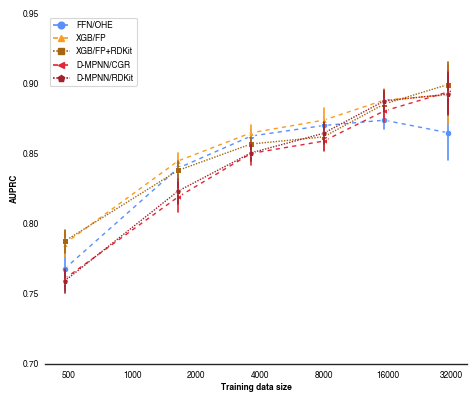

In [137]:
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _2.5
            "JG1375",  # FFN/OHE
            "JG1376",  # XGB/FP
            "JG1377",  # XGB/FP+RDKit
            "JG1378",  # D-MPNN/CGR
            "JG1379",  # D-MPNN/CGR+RDKit
    ],
        [  # _5
            "JG1370",  # FFN/OHE
            "JG1371",  # XGB/FP
            "JG1372",  # XGB/FP+RDKit
            "JG1373",  # D-MPNN/CGR
            "JG1374",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1365",  # FFN/OHE
            "JG1366",  # XGB/FP
            "JG1367",  # XGB/FP+RDKit
            "JG1368",  # D-MPNN/CGR
            "JG1369",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1360",  # FFN/OHE
            "JG1361",  # XGB/FP
            "JG1362",  # XGB/FP+RDKit
            "JG1363",  # D-MPNN/CGR
            "JG1364",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1355",  # FFN/OHE
            "JG1356",  # XGB/FP
            "JG1357",  # XGB/FP+RDKit
            "JG1358",  # D-MPNN/CGR
            "JG1359",  # D-MPNN/CGR+RDKit
    ],
        [  # _80
            "JG1350",  # FFN/OHE
            "JG1351",  # XGB/FP
            "JG1352",  # XGB/FP+RDKit
            "JG1353",  # D-MPNN/CGR
            "JG1354",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["1D_2.5", "1D_5", "1D_10", "1D_20", "1D_40", "1D_80"]
}

chance_level = [get_chance_ap(k, set_type="test") for k in sample_counts.keys()]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

#sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.70, 0.95))
ax.set_xticks(
    [500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['500', '1000', '2000', '4000', '8000', '16000', '32000']
)

ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_1D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_1D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

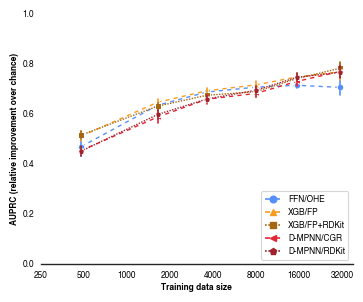

In [135]:
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _2.5
            "JG1375",  # FFN/OHE
            "JG1376",  # XGB/FP
            "JG1377",  # XGB/FP+RDKit
            "JG1378",  # D-MPNN/CGR
            "JG1379",  # D-MPNN/CGR+RDKit
    ],
        [  # _5
            "JG1370",  # FFN/OHE
            "JG1371",  # XGB/FP
            "JG1372",  # XGB/FP+RDKit
            "JG1373",  # D-MPNN/CGR
            "JG1374",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1365",  # FFN/OHE
            "JG1366",  # XGB/FP
            "JG1367",  # XGB/FP+RDKit
            "JG1368",  # D-MPNN/CGR
            "JG1369",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1360",  # FFN/OHE
            "JG1361",  # XGB/FP
            "JG1362",  # XGB/FP+RDKit
            "JG1363",  # D-MPNN/CGR
            "JG1364",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1355",  # FFN/OHE
            "JG1356",  # XGB/FP
            "JG1357",  # XGB/FP+RDKit
            "JG1358",  # D-MPNN/CGR
            "JG1359",  # D-MPNN/CGR+RDKit
    ],
        [  # _80
            "JG1350",  # FFN/OHE
            "JG1351",  # XGB/FP
            "JG1352",  # XGB/FP+RDKit
            "JG1353",  # D-MPNN/CGR
            "JG1354",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["1D_2.5", "1D_5", "1D_10", "1D_20", "1D_40", "1D_80"]
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(3.625, 3))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0, 1))
ax.set_xticks(
    [250, 500, 1000, 2000, 4000, 8000, 16000, 32000], 
    ['250', '500', '1000', '2000', '4000', '8000', '16000', '32000']
)
ax.legend(loc="lower right", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_1D_restricted-data_models_{metric.replace('/', '_')}_relative.svg", format="svg", transparent=True)
fig.savefig(analysis_dir / f"metrics_{datadate}_1D_restricted-data_models_{metric.replace('/', '_')}_relative.png", dpi=300)

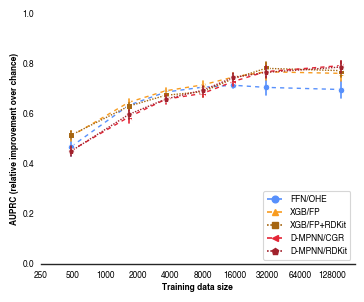

In [136]:
# same as above, but including synthetic data
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [
        [  # _2.5
            "JG1375",  # FFN/OHE
            "JG1376",  # XGB/FP
            "JG1377",  # XGB/FP+RDKit
            "JG1378",  # D-MPNN/CGR
            "JG1379",  # D-MPNN/CGR+RDKit
    ],
        [  # _5
            "JG1370",  # FFN/OHE
            "JG1371",  # XGB/FP
            "JG1372",  # XGB/FP+RDKit
            "JG1373",  # D-MPNN/CGR
            "JG1374",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1365",  # FFN/OHE
            "JG1366",  # XGB/FP
            "JG1367",  # XGB/FP+RDKit
            "JG1368",  # D-MPNN/CGR
            "JG1369",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1360",  # FFN/OHE
            "JG1361",  # XGB/FP
            "JG1362",  # XGB/FP+RDKit
            "JG1363",  # D-MPNN/CGR
            "JG1364",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1355",  # FFN/OHE
            "JG1356",  # XGB/FP
            "JG1357",  # XGB/FP+RDKit
            "JG1358",  # D-MPNN/CGR
            "JG1359",  # D-MPNN/CGR+RDKit
    ],
        [  # _80
            "JG1350",  # FFN/OHE
            "JG1351",  # XGB/FP
            "JG1352",  # XGB/FP+RDKit
            "JG1353",  # D-MPNN/CGR
            "JG1354",  # D-MPNN/CGR+RDKit
    ],
        [  # _80_syn
            "JG1511",  # FFN/OHE
            "JG1512",  # XGB/FP
            "JG1513",  # XGB/FP+RDKit
            "JG1514",  # D-MPNN/CGR
            "JG1515",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["1D_2.5", "1D_5", "1D_10", "1D_20", "1D_40", "1D_80", "1D_80_syn"]
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(3.625, 3))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0, 1))
ax.set_xticks(
    [250*2**n for n in range(10)], 
    [f"{250*2**n}" for n in range(10)],
)

ax.legend(loc="lower right", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_1D_restricted-data_models_{metric.replace('/', '_')}_relative_withsynthetic.svg", format="svg", transparent=True)
fig.savefig(analysis_dir / f"metrics_{datadate}_1D_restricted-data_models_{metric.replace('/', '_')}_relative_withsynthetic.png", dpi=300)

## 2D restricted data splits

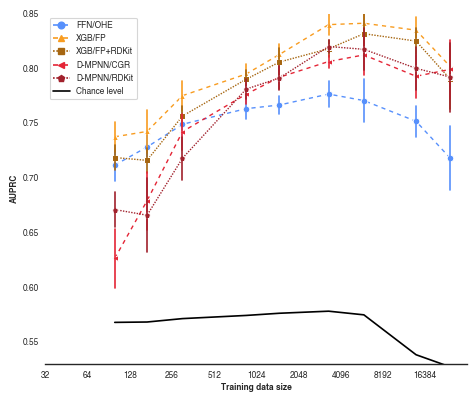

In [65]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"

# choose the data to plot
experiment_ids = [        
        [  # _5
            "JG1420",  # FFN/OHE
            "JG1421",  # XGB/FP
            "JG1422",  # XGB/FP+RDKit
            "JG1423",  # D-MPNN/CGR
            "JG1424",  # D-MPNN/CGR+RDKit
    ],
        [  # _7.5
            "JG1415",  # FFN/OHE
            "JG1416",  # XGB/FP
            "JG1417",  # XGB/FP+RDKit
            "JG1418",  # D-MPNN/CGR
            "JG1419",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1410",  # FFN/OHE
            "JG1411",  # XGB/FP
            "JG1412",  # XGB/FP+RDKit
            "JG1413",  # D-MPNN/CGR
            "JG1414",  # D-MPNN/CGR+RDKit
    ],
        [  # _15
            "JG1405",  # FFN/OHE
            "JG1406",  # XGB/FP
            "JG1407",  # XGB/FP+RDKit
            "JG1408",  # D-MPNN/CGR
            "JG1409",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1400",  # FFN/OHE
            "JG1401",  # XGB/FP
            "JG1402",  # XGB/FP+RDKit
            "JG1403",  # D-MPNN/CGR
            "JG1404",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1395",  # FFN/OHE
            "JG1396",  # XGB/FP
            "JG1397",  # XGB/FP+RDKit
            "JG1398",  # D-MPNN/CGR
            "JG1399",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1390",  # FFN/OHE
            "JG1391",  # XGB/FP
            "JG1392",  # XGB/FP+RDKit
            "JG1393",  # D-MPNN/CGR
            "JG1394",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1385",  # FFN/OHE
            "JG1386",  # XGB/FP
            "JG1387",  # XGB/FP+RDKit
            "JG1388",  # D-MPNN/CGR
            "JG1389",  # D-MPNN/CGR+RDKit
    ],
        [  # _80
            "JG1380",  # FFN/OHE
            "JG1381",  # XGB/FP
            "JG1382",  # XGB/FP+RDKit
            "JG1383",  # D-MPNN/CGR
            "JG1384",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["2D_5", "2D_7.5", "2D_10", "2D_15", "2D_20", "2D_30", "2D_40", "2D_60", "2D_80"]
}

chance_level = [get_chance_ap(k, set_type="val") for k in sample_counts.keys()]  # same order as sample_counts

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.53, 0.85))
ax.set_xticks(
    [32*2**n for n in range(10)], 
    [f"{32*2**n}" for n in range(10)],
)

ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_2D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_2D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

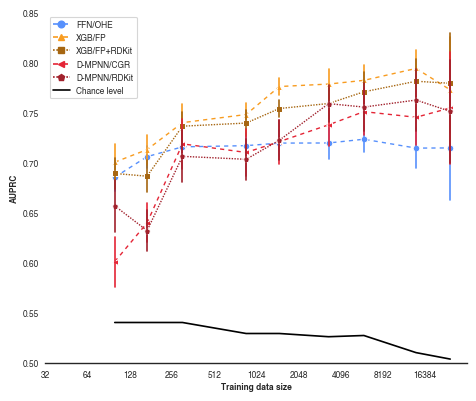

In [66]:
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [        
        [  # _5
            "JG1420",  # FFN/OHE
            "JG1421",  # XGB/FP
            "JG1422",  # XGB/FP+RDKit
            "JG1423",  # D-MPNN/CGR
            "JG1424",  # D-MPNN/CGR+RDKit
    ],
        [  # _7.5
            "JG1415",  # FFN/OHE
            "JG1416",  # XGB/FP
            "JG1417",  # XGB/FP+RDKit
            "JG1418",  # D-MPNN/CGR
            "JG1419",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1410",  # FFN/OHE
            "JG1411",  # XGB/FP
            "JG1412",  # XGB/FP+RDKit
            "JG1413",  # D-MPNN/CGR
            "JG1414",  # D-MPNN/CGR+RDKit
    ],
        [  # _15
            "JG1405",  # FFN/OHE
            "JG1406",  # XGB/FP
            "JG1407",  # XGB/FP+RDKit
            "JG1408",  # D-MPNN/CGR
            "JG1409",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1400",  # FFN/OHE
            "JG1401",  # XGB/FP
            "JG1402",  # XGB/FP+RDKit
            "JG1403",  # D-MPNN/CGR
            "JG1404",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1395",  # FFN/OHE
            "JG1396",  # XGB/FP
            "JG1397",  # XGB/FP+RDKit
            "JG1398",  # D-MPNN/CGR
            "JG1399",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1390",  # FFN/OHE
            "JG1391",  # XGB/FP
            "JG1392",  # XGB/FP+RDKit
            "JG1393",  # D-MPNN/CGR
            "JG1394",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1385",  # FFN/OHE
            "JG1386",  # XGB/FP
            "JG1387",  # XGB/FP+RDKit
            "JG1388",  # D-MPNN/CGR
            "JG1389",  # D-MPNN/CGR+RDKit
    ],
        [  # _80
            "JG1380",  # FFN/OHE
            "JG1381",  # XGB/FP
            "JG1382",  # XGB/FP+RDKit
            "JG1383",  # D-MPNN/CGR
            "JG1384",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["2D_5", "2D_7.5", "2D_10", "2D_15", "2D_20", "2D_30", "2D_40", "2D_60", "2D_80"]
}

chance_level = [get_chance_ap(k, set_type="test") for k in sample_counts.keys()]  # same order as sample_counts

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.5, 0.85))
ax.set_xticks(
    [32*2**n for n in range(10)], 
    [f"{32*2**n}" for n in range(10)],
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_2D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_2D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

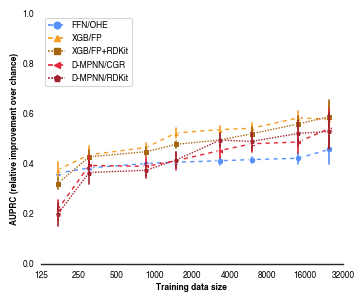

In [75]:
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [        
        [  # _5  do not plot because of excessive variance
            #"JG1420",  # FFN/OHE
            #"JG1421",  # XGB/FP
            #"JG1422",  # XGB/FP+RDKit
            #"JG1423",  # D-MPNN/CGR
            #"JG1424",  # D-MPNN/CGR+RDKit
    ],
        [  # _7.5
            "JG1415",  # FFN/OHE
            "JG1416",  # XGB/FP
            "JG1417",  # XGB/FP+RDKit
            "JG1418",  # D-MPNN/CGR
            "JG1419",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1410",  # FFN/OHE
            "JG1411",  # XGB/FP
            "JG1412",  # XGB/FP+RDKit
            "JG1413",  # D-MPNN/CGR
            "JG1414",  # D-MPNN/CGR+RDKit
    ],
        [  # _15
            "JG1405",  # FFN/OHE
            "JG1406",  # XGB/FP
            "JG1407",  # XGB/FP+RDKit
            "JG1408",  # D-MPNN/CGR
            "JG1409",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1400",  # FFN/OHE
            "JG1401",  # XGB/FP
            "JG1402",  # XGB/FP+RDKit
            "JG1403",  # D-MPNN/CGR
            "JG1404",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1395",  # FFN/OHE
            "JG1396",  # XGB/FP
            "JG1397",  # XGB/FP+RDKit
            "JG1398",  # D-MPNN/CGR
            "JG1399",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1390",  # FFN/OHE
            "JG1391",  # XGB/FP
            "JG1392",  # XGB/FP+RDKit
            "JG1393",  # D-MPNN/CGR
            "JG1394",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1385",  # FFN/OHE
            "JG1386",  # XGB/FP
            "JG1387",  # XGB/FP+RDKit
            "JG1388",  # D-MPNN/CGR
            "JG1389",  # D-MPNN/CGR+RDKit
    ],
        [  # _80
            "JG1380",  # FFN/OHE
            "JG1381",  # XGB/FP
            "JG1382",  # XGB/FP+RDKit
            "JG1383",  # D-MPNN/CGR
            "JG1384",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["2D_5", "2D_7.5", "2D_10", "2D_15", "2D_20", "2D_30", "2D_40", "2D_60", "2D_80"]
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(3.625, 3))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0., 1))
ax.set_xticks(
    [125*2**n for n in range(9)], 
    [f"{125*2**n}" for n in range(9)],
)
legend = ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_2D_restricted-data_models_{metric.replace('/', '_')}_relative.svg", format="svg", transparent=True)
fig.savefig(analysis_dir / f"metrics_{datadate}_2D_restricted-data_models_{metric.replace('/', '_')}_relative.png", dpi=300)

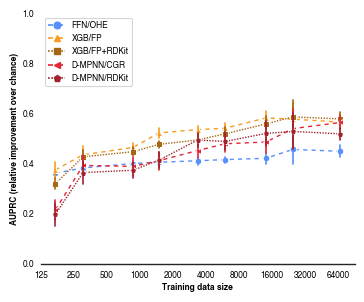

In [139]:
# same as above, but with synthetic data
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [        
        [  # _5  do not plot because of excessive variance
            #"JG1420",  # FFN/OHE
            #"JG1421",  # XGB/FP
            #"JG1422",  # XGB/FP+RDKit
            #"JG1423",  # D-MPNN/CGR
            #"JG1424",  # D-MPNN/CGR+RDKit
    ],
        [  # _7.5
            "JG1415",  # FFN/OHE
            "JG1416",  # XGB/FP
            "JG1417",  # XGB/FP+RDKit
            "JG1418",  # D-MPNN/CGR
            "JG1419",  # D-MPNN/CGR+RDKit
    ],
        [  # _10
            "JG1410",  # FFN/OHE
            "JG1411",  # XGB/FP
            "JG1412",  # XGB/FP+RDKit
            "JG1413",  # D-MPNN/CGR
            "JG1414",  # D-MPNN/CGR+RDKit
    ],
        [  # _15
            "JG1405",  # FFN/OHE
            "JG1406",  # XGB/FP
            "JG1407",  # XGB/FP+RDKit
            "JG1408",  # D-MPNN/CGR
            "JG1409",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1400",  # FFN/OHE
            "JG1401",  # XGB/FP
            "JG1402",  # XGB/FP+RDKit
            "JG1403",  # D-MPNN/CGR
            "JG1404",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1395",  # FFN/OHE
            "JG1396",  # XGB/FP
            "JG1397",  # XGB/FP+RDKit
            "JG1398",  # D-MPNN/CGR
            "JG1399",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1390",  # FFN/OHE
            "JG1391",  # XGB/FP
            "JG1392",  # XGB/FP+RDKit
            "JG1393",  # D-MPNN/CGR
            "JG1394",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1385",  # FFN/OHE
            "JG1386",  # XGB/FP
            "JG1387",  # XGB/FP+RDKit
            "JG1388",  # D-MPNN/CGR
            "JG1389",  # D-MPNN/CGR+RDKit
    ],
        [  # _80
            "JG1380",  # FFN/OHE
            "JG1381",  # XGB/FP
            "JG1382",  # XGB/FP+RDKit
            "JG1383",  # D-MPNN/CGR
            "JG1384",  # D-MPNN/CGR+RDKit
    ],
        [  # _60_syn
            "JG1516",  # FFN/OHE
            "JG1517",  # XGB/FP
            "JG1518",  # XGB/FP+RDKit
            "JG1519",  # D-MPNN/CGR
            "JG1520",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["2D_5", "2D_7.5", "2D_10", "2D_15", "2D_20", "2D_30", "2D_40", "2D_60", "2D_80", "2D_60_syn"]
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(3.625, 3))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0., 1))
ax.set_xticks(
    [125*2**n for n in range(10)], 
    [f"{125*2**n}" for n in range(10)],
)
legend = ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_2D_restricted-data_models_{metric.replace('/', '_')}_relative_withsynthetic.svg", format="svg", transparent=True)
fig.savefig(analysis_dir / f"metrics_{datadate}_2D_restricted-data_models_{metric.replace('/', '_')}_relative_withsynthetic.png", dpi=300)

## 3D restricted data splits

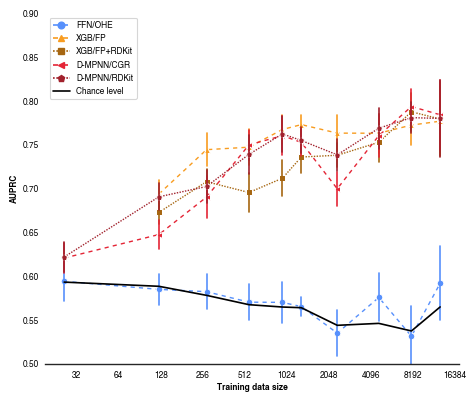

In [85]:
# choose the metric, i.e. accuracy or AUROC
metric = "val/avgPrecision_macro"

# choose the data to plot
experiment_ids = [        
        [  # _10
            "JG1475",  # FFN/OHE
            "JG1476",  # XGB/FP
            "JG1477",  # XGB/FP+RDKit
            "JG1478",  # D-MPNN/CGR
            "JG1479",  # D-MPNN/CGR+RDKit
    ],
        [  # _15
            "JG1470",  # FFN/OHE
            "JG1471",  # XGB/FP
            "JG1472",  # XGB/FP+RDKit
            "JG1473",  # D-MPNN/CGR
            "JG1474",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1465",  # FFN/OHE
            "JG1466",  # XGB/FP
            "JG1467",  # XGB/FP+RDKit
            "JG1468",  # D-MPNN/CGR
            "JG1469",  # D-MPNN/CGR+RDKit
    ],
        [  # _25
            "JG1460",  # FFN/OHE
            "JG1461",  # XGB/FP
            "JG1462",  # XGB/FP+RDKit
            "JG1463",  # D-MPNN/CGR
            "JG1464",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1455",  # FFN/OHE
            "JG1456",  # XGB/FP
            "JG1457",  # XGB/FP+RDKit
            "JG1458",  # D-MPNN/CGR
            "JG1459",  # D-MPNN/CGR+RDKit
    ],
        [  # _34
            "JG1450",  # FFN/OHE
            "JG1451",  # XGB/FP
            "JG1452",  # XGB/FP+RDKit
            "JG1453",  # D-MPNN/CGR
            "JG1454",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1445",  # FFN/OHE
            "JG1446",  # XGB/FP
            "JG1447",  # XGB/FP+RDKit
            "JG1448",  # D-MPNN/CGR
            "JG1449",  # D-MPNN/CGR+RDKit
    ],
        [  # _50
            "JG1440",  # FFN/OHE
            "JG1441",  # XGB/FP
            "JG1442",  # XGB/FP+RDKit
            "JG1443",  # D-MPNN/CGR
            "JG1444",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1435",  # FFN/OHE
            "JG1436",  # XGB/FP
            "JG1437",  # XGB/FP+RDKit
            "JG1438",  # D-MPNN/CGR
            "JG1439",  # D-MPNN/CGR+RDKit
    ],
        [  # _70
            "JG1430",  # FFN/OHE
            "JG1431",  # XGB/FP
            "JG1432",  # XGB/FP+RDKit
            "JG1433",  # D-MPNN/CGR
            "JG1434",  # D-MPNN/CGR+RDKit
    ],
#        [  # _80  # do not plot b/c excessive variance
#            "JG1425",  # FFN/OHE
#            "JG1426",  # XGB/FP
#            "JG1427",  # XGB/FP+RDKit
#            "JG1428",  # D-MPNN/CGR
#            "JG1429",  # D-MPNN/CGR+RDKit
#    ],
]


sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["3D_10", "3D_15", "3D_20", "3D_25", "3D_30", "3D_34", "3D_40", "3D_50", "3D_60", "3D_70"]
}

chance_level = [get_chance_ap(k, set_type="val") for k in sample_counts.keys()]  # same order as sample_counts


exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    style="Model+Features",
    hue="Model+Features",
    hue_order=order,
    style_order=order,
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.5, 0.9))
ax.set_xticks(
    [32*2**n for n in range(10)], 
    [f"{32*2**n}" for n in range(10)],
)
ax.legend(loc="upper left", title=None)


fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

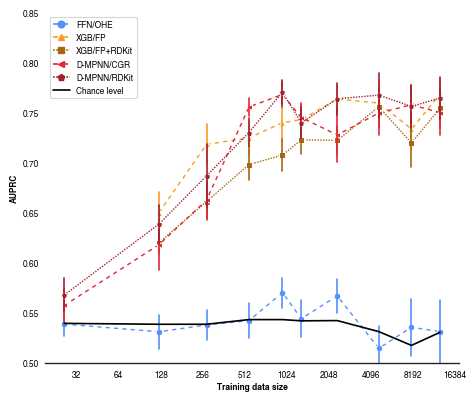

In [88]:
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [        
        [  # _10
            "JG1475",  # FFN/OHE
            "JG1476",  # XGB/FP
            "JG1477",  # XGB/FP+RDKit
            "JG1478",  # D-MPNN/CGR
            "JG1479",  # D-MPNN/CGR+RDKit
    ],
        [  # _15
            "JG1470",  # FFN/OHE
            "JG1471",  # XGB/FP
            "JG1472",  # XGB/FP+RDKit
            "JG1473",  # D-MPNN/CGR
            "JG1474",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1465",  # FFN/OHE
            "JG1466",  # XGB/FP
            "JG1467",  # XGB/FP+RDKit
            "JG1468",  # D-MPNN/CGR
            "JG1469",  # D-MPNN/CGR+RDKit
    ],
        [  # _25
            "JG1460",  # FFN/OHE
            "JG1461",  # XGB/FP
            "JG1462",  # XGB/FP+RDKit
            "JG1463",  # D-MPNN/CGR
            "JG1464",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1455",  # FFN/OHE
            "JG1456",  # XGB/FP
            "JG1457",  # XGB/FP+RDKit
            "JG1458",  # D-MPNN/CGR
            "JG1459",  # D-MPNN/CGR+RDKit
    ],
        [  # _34
            "JG1450",  # FFN/OHE
            "JG1451",  # XGB/FP
            "JG1452",  # XGB/FP+RDKit
            "JG1453",  # D-MPNN/CGR
            "JG1454",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1445",  # FFN/OHE
            "JG1446",  # XGB/FP
            "JG1447",  # XGB/FP+RDKit
            "JG1448",  # D-MPNN/CGR
            "JG1449",  # D-MPNN/CGR+RDKit
    ],
        [  # _50
            "JG1440",  # FFN/OHE
            "JG1441",  # XGB/FP
            "JG1442",  # XGB/FP+RDKit
            "JG1443",  # D-MPNN/CGR
            "JG1444",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1435",  # FFN/OHE
            "JG1436",  # XGB/FP
            "JG1437",  # XGB/FP+RDKit
            "JG1438",  # D-MPNN/CGR
            "JG1439",  # D-MPNN/CGR+RDKit
    ],
        [  # _70
            "JG1430",  # FFN/OHE
            "JG1431",  # XGB/FP
            "JG1432",  # XGB/FP+RDKit
            "JG1433",  # D-MPNN/CGR
            "JG1434",  # D-MPNN/CGR+RDKit
    ],
#        [  # _80  # do not plot b/c excessive variance
#            "JG1425",  # FFN/OHE
#            "JG1426",  # XGB/FP
#            "JG1427",  # XGB/FP+RDKit
#            "JG1428",  # D-MPNN/CGR
#            "JG1429",  # D-MPNN/CGR+RDKit
#    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["3D_10", "3D_15", "3D_20", "3D_25", "3D_30", "3D_34", "3D_40", "3D_50", "3D_60", "3D_70"]
}

chance_level = [get_chance_ap(k, set_type="test") for k in sample_counts.keys()]  # same order as sample_counts

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    dashes=dashes,
    errorbar=errorbar,
    err_style="bars",
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.5, 0.85))
ax.set_xticks(
    [32*2**n for n in range(10)], 
    [f"{32*2**n}" for n in range(10)],
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

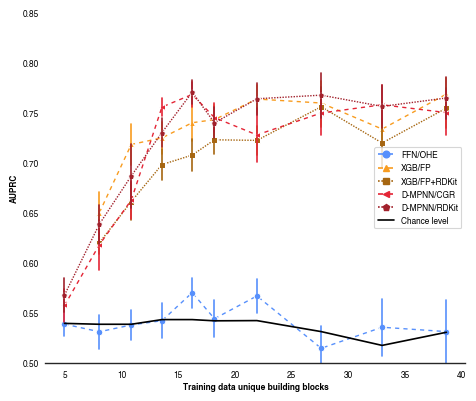

In [110]:
# repetition of the last plot, but with number of seen building blocks on the x axis instead of training samples
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
experiment_ids = [        
        [  # _10
            "JG1475",  # FFN/OHE
            "JG1476",  # XGB/FP
            "JG1477",  # XGB/FP+RDKit
            "JG1478",  # D-MPNN/CGR
            "JG1479",  # D-MPNN/CGR+RDKit
    ],
        [  # _15
            "JG1470",  # FFN/OHE
            "JG1471",  # XGB/FP
            "JG1472",  # XGB/FP+RDKit
            "JG1473",  # D-MPNN/CGR
            "JG1474",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1465",  # FFN/OHE
            "JG1466",  # XGB/FP
            "JG1467",  # XGB/FP+RDKit
            "JG1468",  # D-MPNN/CGR
            "JG1469",  # D-MPNN/CGR+RDKit
    ],
        [  # _25
            "JG1460",  # FFN/OHE
            "JG1461",  # XGB/FP
            "JG1462",  # XGB/FP+RDKit
            "JG1463",  # D-MPNN/CGR
            "JG1464",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1455",  # FFN/OHE
            "JG1456",  # XGB/FP
            "JG1457",  # XGB/FP+RDKit
            "JG1458",  # D-MPNN/CGR
            "JG1459",  # D-MPNN/CGR+RDKit
    ],
        [  # _34
            "JG1450",  # FFN/OHE
            "JG1451",  # XGB/FP
            "JG1452",  # XGB/FP+RDKit
            "JG1453",  # D-MPNN/CGR
            "JG1454",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1445",  # FFN/OHE
            "JG1446",  # XGB/FP
            "JG1447",  # XGB/FP+RDKit
            "JG1448",  # D-MPNN/CGR
            "JG1449",  # D-MPNN/CGR+RDKit
    ],
        [  # _50
            "JG1440",  # FFN/OHE
            "JG1441",  # XGB/FP
            "JG1442",  # XGB/FP+RDKit
            "JG1443",  # D-MPNN/CGR
            "JG1444",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1435",  # FFN/OHE
            "JG1436",  # XGB/FP
            "JG1437",  # XGB/FP+RDKit
            "JG1438",  # D-MPNN/CGR
            "JG1439",  # D-MPNN/CGR+RDKit
    ],
        [  # _70
            "JG1430",  # FFN/OHE
            "JG1431",  # XGB/FP
            "JG1432",  # XGB/FP+RDKit
            "JG1433",  # D-MPNN/CGR
            "JG1434",  # D-MPNN/CGR+RDKit
    ],
#        [  # _80  # do not plot b/c excessive variance
#            "JG1425",  # FFN/OHE
#            "JG1426",  # XGB/FP
#            "JG1427",  # XGB/FP+RDKit
#            "JG1428",  # D-MPNN/CGR
#            "JG1429",  # D-MPNN/CGR+RDKit
#    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_buildingblock_count(k)
    for k in ["3D_10", "3D_15", "3D_20", "3D_25", "3D_30", "3D_34", "3D_40", "3D_50", "3D_60", "3D_70"]
}

chance_level = [get_chance_ap(k, set_type="test") for k in sample_counts.keys()]  # same order as sample_counts

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# set plot
fig, ax = plt.subplots(figsize=(4.75,4))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=metric,
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    dashes=dashes,
    errorbar=errorbar,
    err_style="bars",
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

sns.lineplot(x=sample_counts.values(), y=chance_level, c="black", label="Chance level")

ax.set_xlabel("Training data unique building blocks")
ax.set_ylabel("AUPRC")
#ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0.5, 0.85))
#ax.set_xticks(
#    [32*2**n for n in range(10)], 
#    [f"{32*2**n}" for n in range(10)],
#)
ax.legend(loc="center right", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}.svg", format="svg")
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}.png", dpi=300)

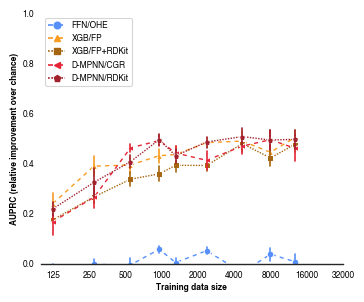

In [116]:
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
# choose the data to plot
experiment_ids = [        
#        [  # _10  # do not plot b/c XGB results not available
#            "JG1475",  # FFN/OHE
#            "JG1476",  # XGB/FP
#            "JG1477",  # XGB/FP+RDKit
#            "JG1478",  # D-MPNN/CGR
#            "JG1479",  # D-MPNN/CGR+RDKit
#    ],
        [  # _15
            "JG1470",  # FFN/OHE
            "JG1471",  # XGB/FP
            "JG1472",  # XGB/FP+RDKit
            "JG1473",  # D-MPNN/CGR
            "JG1474",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1465",  # FFN/OHE
            "JG1466",  # XGB/FP
            "JG1467",  # XGB/FP+RDKit
            "JG1468",  # D-MPNN/CGR
            "JG1469",  # D-MPNN/CGR+RDKit
    ],
        [  # _25
            "JG1460",  # FFN/OHE
            "JG1461",  # XGB/FP
            "JG1462",  # XGB/FP+RDKit
            "JG1463",  # D-MPNN/CGR
            "JG1464",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1455",  # FFN/OHE
            "JG1456",  # XGB/FP
            "JG1457",  # XGB/FP+RDKit
            "JG1458",  # D-MPNN/CGR
            "JG1459",  # D-MPNN/CGR+RDKit
    ],
        [  # _34
            "JG1450",  # FFN/OHE
            "JG1451",  # XGB/FP
            "JG1452",  # XGB/FP+RDKit
            "JG1453",  # D-MPNN/CGR
            "JG1454",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1445",  # FFN/OHE
            "JG1446",  # XGB/FP
            "JG1447",  # XGB/FP+RDKit
            "JG1448",  # D-MPNN/CGR
            "JG1449",  # D-MPNN/CGR+RDKit
    ],
        [  # _50
            "JG1440",  # FFN/OHE
            "JG1441",  # XGB/FP
            "JG1442",  # XGB/FP+RDKit
            "JG1443",  # D-MPNN/CGR
            "JG1444",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1435",  # FFN/OHE
            "JG1436",  # XGB/FP
            "JG1437",  # XGB/FP+RDKit
            "JG1438",  # D-MPNN/CGR
            "JG1439",  # D-MPNN/CGR+RDKit
    ],
        [  # _70
            "JG1430",  # FFN/OHE
            "JG1431",  # XGB/FP
            "JG1432",  # XGB/FP+RDKit
            "JG1433",  # D-MPNN/CGR
            "JG1434",  # D-MPNN/CGR+RDKit
    ],
#        [  # _80  # do not plot b/c excessive variance
#            "JG1425",  # FFN/OHE
#            "JG1426",  # XGB/FP
#            "JG1427",  # XGB/FP+RDKit
#            "JG1428",  # D-MPNN/CGR
#            "JG1429",  # D-MPNN/CGR+RDKit
#    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["3D_10", "3D_15", "3D_20", "3D_25", "3D_30", "3D_34", "3D_40", "3D_50", "3D_60", "3D_70"]
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(3.625, 3))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0., 1.))
ax.set_xticks(
    [125*2**n for n in range(9)], 
    [f"{125*2**n}" for n in range(9)],
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}_relative.svg", format="svg", transparent=True)
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}_relative.png", dpi=300)

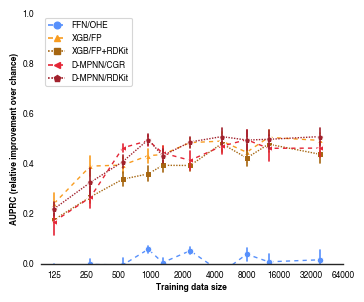

In [140]:
# same as above, but including synthetic data
# Plot scaled using chance level for better comparability across sizes
# i.e. we divide by the chance level so that the chance result is now 0 and best is still 1
# choose the metric, i.e. accuracy or AUROC
metric = "test/avgPrecision_macro"

# choose the data to plot
# choose the data to plot
experiment_ids = [        
#        [  # _10  # do not plot b/c XGB results not available
#            "JG1475",  # FFN/OHE
#            "JG1476",  # XGB/FP
#            "JG1477",  # XGB/FP+RDKit
#            "JG1478",  # D-MPNN/CGR
#            "JG1479",  # D-MPNN/CGR+RDKit
#    ],
        [  # _15
            "JG1470",  # FFN/OHE
            "JG1471",  # XGB/FP
            "JG1472",  # XGB/FP+RDKit
            "JG1473",  # D-MPNN/CGR
            "JG1474",  # D-MPNN/CGR+RDKit
    ],
        [  # _20
            "JG1465",  # FFN/OHE
            "JG1466",  # XGB/FP
            "JG1467",  # XGB/FP+RDKit
            "JG1468",  # D-MPNN/CGR
            "JG1469",  # D-MPNN/CGR+RDKit
    ],
        [  # _25
            "JG1460",  # FFN/OHE
            "JG1461",  # XGB/FP
            "JG1462",  # XGB/FP+RDKit
            "JG1463",  # D-MPNN/CGR
            "JG1464",  # D-MPNN/CGR+RDKit
    ],
        [  # _30
            "JG1455",  # FFN/OHE
            "JG1456",  # XGB/FP
            "JG1457",  # XGB/FP+RDKit
            "JG1458",  # D-MPNN/CGR
            "JG1459",  # D-MPNN/CGR+RDKit
    ],
        [  # _34
            "JG1450",  # FFN/OHE
            "JG1451",  # XGB/FP
            "JG1452",  # XGB/FP+RDKit
            "JG1453",  # D-MPNN/CGR
            "JG1454",  # D-MPNN/CGR+RDKit
    ],
        [  # _40
            "JG1445",  # FFN/OHE
            "JG1446",  # XGB/FP
            "JG1447",  # XGB/FP+RDKit
            "JG1448",  # D-MPNN/CGR
            "JG1449",  # D-MPNN/CGR+RDKit
    ],
        [  # _50
            "JG1440",  # FFN/OHE
            "JG1441",  # XGB/FP
            "JG1442",  # XGB/FP+RDKit
            "JG1443",  # D-MPNN/CGR
            "JG1444",  # D-MPNN/CGR+RDKit
    ],
        [  # _60
            "JG1435",  # FFN/OHE
            "JG1436",  # XGB/FP
            "JG1437",  # XGB/FP+RDKit
            "JG1438",  # D-MPNN/CGR
            "JG1439",  # D-MPNN/CGR+RDKit
    ],
        [  # _70
            "JG1430",  # FFN/OHE
            "JG1431",  # XGB/FP
            "JG1432",  # XGB/FP+RDKit
            "JG1433",  # D-MPNN/CGR
            "JG1434",  # D-MPNN/CGR+RDKit
    ],
#        [  # _80  # do not plot b/c excessive variance
#            "JG1425",  # FFN/OHE
#            "JG1426",  # XGB/FP
#            "JG1427",  # XGB/FP+RDKit
#            "JG1428",  # D-MPNN/CGR
#            "JG1429",  # D-MPNN/CGR+RDKit
#    ],
        [  # _60_syn
            "JG1521",  # FFN/OHE
            "JG1522",  # XGB/FP
            "JG1523",  # XGB/FP+RDKit
            "JG1524",  # D-MPNN/CGR
            "JG1525",  # D-MPNN/CGR+RDKit
    ],
]

sample_counts = {  # mean number of training samples for each split 
    k: get_sample_count(k)
    for k in ["3D_10", "3D_15", "3D_20", "3D_25", "3D_30", "3D_34", "3D_40", "3D_50", "3D_60", "3D_70", "3D_60_syn"]
}

exps = [i for exp in experiment_ids for i in exp]
# filter the data
df_plot = df_all.loc[df_all['experiment_id'].isin(exps)]

# sort the values
sort_dict = dict(zip(exps, itertools.count()))
df_plot_x = df_plot.sort_values(by="experiment_id", kind="mergesort", key=lambda x: x.map(sort_dict)).copy()
df_plot_x["x"] = df_plot_x["tags"].apply(lambda x: sample_counts[x[0]])

# divide by chance level. Note that we obtain the chance level per individual fold so that the SEM still makes sense after scaling.
df_plot_x[f"{metric}_scaled"] = (df_plot_x[metric] - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1)) / (1 - df_plot_x.apply(lambda x: get_chance_ap(x["tags"][0], x["fold"], "test"), axis=1))

# set plot
fig, ax = plt.subplots(figsize=(3.625, 3))
sns.lineplot(
    ax=ax,
    data=df_plot_x, 
    x="x",
    y=f"{metric}_scaled",
    palette=palette,
    hue_order=order,
    style_order=order,
    style="Model+Features",
    hue="Model+Features",
    errorbar=errorbar,
    err_style="bars",
    dashes=dashes,
    linewidth=linewidth,
    markers=["o", "^", "s", "<", "p"],
)

ax.set_xlabel("Training data size")
ax.set_ylabel("AUPRC (relative improvement over chance)")
ax.set_xscale("log")
ax.xaxis.set_tick_params(labelrotation=0)
ax.set_ylim((0., 1.))
ax.set_xticks(
    [125*2**n for n in range(10)], 
    [f"{125*2**n}" for n in range(10)],
)
ax.legend(loc="upper left", title=None)

fig.tight_layout()
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}_relative_withsynthetic.svg", format="svg", transparent=True)
fig.savefig(analysis_dir / f"metrics_{datadate}_3D_restricted-data_models_{metric.replace('/', '_')}_relative_withsynthetic.png", dpi=300)
